In [22]:
import os
import time
import math
import copy
import json
import logging

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [102]:
from sklearn.metrics import accuracy_score

In [23]:
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

%matplotlib inline

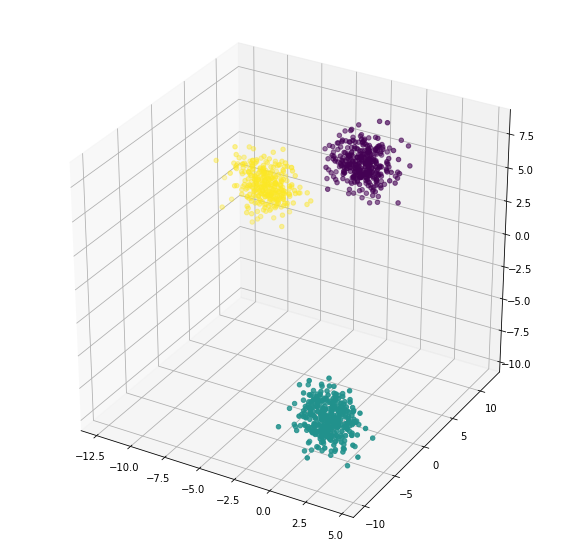

In [24]:
XX, yyy = make_blobs(2000, n_features=3, random_state=42)


X = XX[0:1000]
yy = yyy[0:1000]

X_test = XX[1000:]
yy_test = yyy[1000:]


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=yy)


# convert to pytorch tensors
X = torch.FloatTensor(X)
y = torch.zeros(X.size(0), 3)
for idx, _ in enumerate(yy):
    y[idx, _] = 1.0

X_test = torch.FloatTensor(X_test)
   
y_test = torch.zeros(X_test.size(0), 3)
for idx, _ in enumerate(yy_test):
    y_test[idx, _] = 1.0

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 3),
            nn.ReLU(True),
            nn.Linear(3, 3)
        )
    
    def forward(self, x):
        return self.layers(x)

    def compute_loss(self, x, y):
        out = self(x)
        return F.binary_cross_entropy_with_logits(out, y)


### Train a network until it learns to predict all ones for the output

In [26]:
def sem_loss(probs):
    s = torch.zeros(1)
    
    for i, p_i in enumerate(probs):
        s_part = p_i
        for j, p_j in enumerate(probs):
            if i == j:
                continue
            s_part = torch.mul(s_part, (1 - p_j))
        s += s_part
    return -1 * torch.log(s)

In [6]:
np.random.seed(42)
torch.manual_seed(42)

net = Net()

opt = optim.Adam(net.parameters())
for i in range(3000):    
    opt.zero_grad()
    loss = net.compute_loss(X, torch.ones(X.size(0), 3))
    loss.backward()
    opt.step()
#     print(loss.item())
    
    with torch.no_grad():
        
        y_pred = torch.sigmoid(net(X))
        # accuracy_score(yy, y_pred.detach().numpy().argmax(1))
        y_pred[y_pred > 0.5] = 1
        all_ones = (y_pred == 1.0).view(-1).sum()
#         print(all_ones)
        if all_ones == np.prod(y_pred.shape):
            break

print("All ones: DONE!")            
### Now train only with the semantic loss and note the number of constraints it satisfies 
opt = optim.Adam(net.parameters(), lr=0.01)
loss_ot = []
sat_ot = []
for i in range(100):    
    opt.zero_grad()
    out = net(X)
    batch_loss = torch.zeros(X.size(0))
    for i, o in enumerate(out):
        batch_loss[i] = sem_loss(torch.sigmoid(o))
    loss = batch_loss.mean()
    loss.backward()
    opt.step()

    loss_ot.append(loss.item())
    
    
    with torch.no_grad():
        y_pred = torch.sigmoid(net(X))
        logits = copy.deepcopy(y_pred)
        logits[logits > 0.5] = 1
        logits[logits <= 0.5] = 0
        sat = logits.sum(dim=1)
        sat = (sat == 1).sum()
        sat_ot.append(sat)
        print(sat, loss.item())
#         if sat == X.size(0):
                    

All ones: DONE!
tensor(0) 2.952587127685547
tensor(0) 2.776423692703247
tensor(0) 2.611624002456665
tensor(0) 2.458329677581787
tensor(0) 2.3160877227783203
tensor(0) 2.184173822402954
tensor(0) 2.0619778633117676
tensor(0) 1.9489762783050537
tensor(0) 1.8445531129837036
tensor(0) 1.7480207681655884
tensor(0) 1.6589642763137817
tensor(0) 1.5768227577209473
tensor(1) 1.5011385679244995
tensor(9) 1.4314870834350586
tensor(48) 1.367394208908081
tensor(125) 1.3083512783050537
tensor(227) 1.2538973093032837
tensor(306) 1.2035998106002808
tensor(345) 1.1570279598236084
tensor(399) 1.1137431859970093
tensor(510) 1.0733181238174438
tensor(624) 1.0353156328201294
tensor(673) 0.9992255568504333
tensor(686) 0.9645546078681946
tensor(703) 0.9308790564537048
tensor(731) 0.8978963494300842
tensor(759) 0.8652868270874023
tensor(785) 0.832659900188446
tensor(829) 0.8000270128250122
tensor(859) 0.7673029899597168
tensor(886) 0.734456479549408
tensor(912) 0.7016273736953735
tensor(932) 0.668989777565002

In [ ]:
fig = plt.figure(figsize=(12, 5))

# first position at which # of points == 1000
sat_pos = sat_ot.index(1000)

ax = fig.add_subplot(121)
ax.plot(loss_ot, label="Semantic Loss")
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.set_title("Loss over iterations")
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)


ax = fig.add_subplot(122)
ax.plot(sat_ot, label="No. points Satisfied")
ax.axhline(1000, 0, len(sat_ot), label="No. points", linestyle="--", color="red", alpha=0.7)
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("No. of points")
ax.set_title("Number of points that satisfy the exactly-once constraint")

plt.savefig("./gaussian_blobs.png", dpi=300)

### Experiment 2

In this experiment, we want to push the network to learn the following constraint:

$$(x_1 \land x_2 \land \neg x_3) \lor (\neg x_1 \land \neg x_2 \land x_3)$$

i.e we want either the first two logits to be active or the last logit to be active

In [80]:
def sem_loss_2(probs):
    # this loss forces either
    #    (a) the first two classes to be one (together)
    # or (b) the last class to be one
    assert probs.size(0) == 3
    
    s1 = probs[0] * probs[1] * (1- probs[2])
    s2 = (1-probs[0]) * (1-probs[1]) * probs[2]
    
    return -1 * torch.log(s1 + s2)

In [81]:
def sat_exactly2(logits):
    assert logits.size(1) == 3
    sat = 0
    for l in logits:
        if l[0] == 1 and l[1] == 1 and l[2] == 0:
            sat += 1
        elif l[0] == 0 and l[1] == 0 and l[2] == 1:
            sat += 1
    return sat

In [82]:
a = torch.Tensor([
    [0, 0, 1],
    [1, 1, 0]
])

sat_exactly2(a)

2

In [90]:
np.random.seed(40)
torch.manual_seed(40)

net = Net()

opt = optim.Adam(net.parameters())
for i in range(3000):    
    opt.zero_grad()
    loss = net.compute_loss(X, torch.ones(X.size(0), 3))
    loss.backward()
    opt.step()
#     print(loss.item())
    
    with torch.no_grad():
        
        y_pred = torch.sigmoid(net(X))
        # accuracy_score(yy, y_pred.detach().numpy().argmax(1))
        y_pred[y_pred > 0.5] = 1
        all_ones = (y_pred == 1.0).view(-1).sum()
#         print(all_ones)
        if all_ones == np.prod(y_pred.shape):
            break

print("All ones: DONE!")            
### Now train only with the semantic loss and note the number of constraints it satisfies 
opt = optim.Adam(net.parameters(), lr=0.01)
loss_ot = []
sat_ot = []
for i in range(100):    
    opt.zero_grad()
    out = net(X)
    batch_loss = torch.zeros(X.size(0))
    for i, o in enumerate(out):
        batch_loss[i] = sem_loss_2(torch.sigmoid(o))
    loss = batch_loss.mean()
    loss.backward()
    opt.step()

    loss_ot.append(loss.item())
    
    if i % 10 == 0:
        print(logits[:3])
    
    with torch.no_grad():
        y_pred = torch.sigmoid(net(X))
        logits = copy.deepcopy(y_pred)
        logits[logits > 0.5] = 1
        logits[logits <= 0.5] = 0
        
        sat = sat_exactly2(logits)
        print(sat, loss.item())
        
        sat_ot.append(sat)

All ones: DONE!
0 2.3396408557891846
25 2.1813437938690186
120 2.025027275085449
238 1.8714460134506226
312 1.7214136123657227
336 1.5757967233657837
337 1.4355226755142212
337 1.3015568256378174
368 1.1748534440994263
607 1.05628502368927
676 0.9465638995170593
725 0.846168041229248
966 0.7552893757820129
999 0.6738171577453613
1000 0.6013615727424622
1000 0.537309467792511
1000 0.480899840593338
1000 0.4313006103038788
1000 0.3876757323741913
1000 0.3492327034473419
1000 0.31525278091430664
1000 0.28510454297065735
1000 0.2582460641860962
1000 0.2342163473367691
1000 0.21263666450977325
1000 0.19319495558738708
1000 0.17563147842884064
1000 0.1597319394350052
1000 0.14531446993350983
1000 0.1322353184223175
1000 0.12036839872598648
1000 0.10960429906845093
1000 0.09984701871871948
1000 0.09101008623838425
1000 0.0830163061618805
1000 0.0757966861128807
1000 0.06928608566522598
1000 0.06342031806707382
1000 0.05814303830265999
1000 0.05339997634291649
1000 0.049140091985464096
1000 0.

In [91]:
logits

tensor([[1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        ...,
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.]])

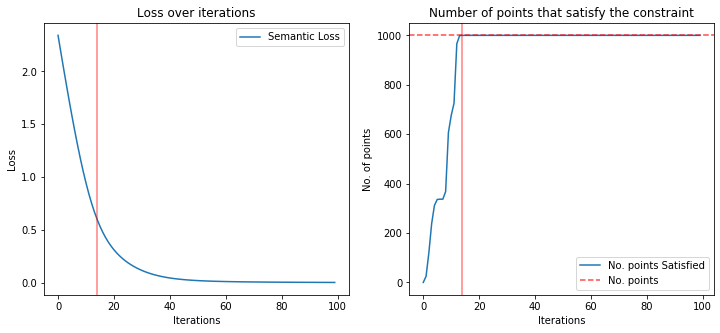

In [92]:
fig = plt.figure(figsize=(12, 5))

# first position at which # of points == 1000
sat_pos = sat_ot.index(1000)

ax = fig.add_subplot(121)
ax.plot(loss_ot, label="Semantic Loss")
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.set_title("Loss over iterations")
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)


ax = fig.add_subplot(122)
ax.plot(sat_ot, label="No. points Satisfied")
ax.axhline(1000, 0, len(sat_ot), label="No. points", linestyle="--", color="red", alpha=0.7)
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("No. of points")
ax.set_title("Number of points that satisfy the constraint")

plt.savefig("./gaussian_blobs_exp2.png", dpi=300)

### Experiment 3: Bias

In this experiment, we will investigate our intuition about the SL. We first train a network to predict the proper class in the GB dataset. Then we will use the SL to enforce the constraint defined in Experiment 2. Our hypothesis is that the network will predict (0, 0, 1) on 1/3rd of the dataset and (1, 1, 0) on 2/3rd of the dataset.      

In [94]:
def sat_exactly2_parts(logits):
    assert logits.size(1) == 3
    sat_1 = 0
    sat_2 = 0
    for l in logits:
        if l[0] == 1 and l[1] == 1 and l[2] == 0:
            sat_1 += 1
        elif l[0] == 0 and l[1] == 0 and l[2] == 1:
            sat_2 += 1
    return sat_1 + sat_2, sat_1, sat_2

In [121]:
np.random.seed(42)
torch.manual_seed(42)

net = Net()

opt = optim.Adam(net.parameters())
for i in range(3000):    
    opt.zero_grad()
    loss = net.compute_loss(X, y)
    loss.backward()
    opt.step()
#     print(loss.item())
    
    with torch.no_grad():
        
        y_pred = torch.sigmoid(net(X))
        y_pred[y_pred > 0.5] = 1
        acc = accuracy_score(y.argmax(1), y_pred.detach().numpy().argmax(1))
        if acc == 1.0:
            break

print("Gauss Blobs done!")

### Now train only with the semantic loss and note the number of constraints it satisfies 
opt = optim.Adam(net.parameters(), lr=0.01)
loss_ot = []
sat_ot = []
sat_1_ot = []
sat_2_ot = []
acc_ot = []
for i in range(100):    
    opt.zero_grad()
    out = net(X)
    batch_loss = torch.zeros(X.size(0))
    for i, o in enumerate(out):
        batch_loss[i] = sem_loss_2(torch.sigmoid(o))
    loss = batch_loss.mean()
    loss.backward()
    opt.step()

    loss_ot.append(loss.item())
    
    if i % 10 == 0:
        print(logits[:3])
    
    with torch.no_grad():
        y_pred = torch.sigmoid(net(X))        
        y_pred[y_pred > 0.5] = 1
        acc = accuracy_score(y.argmax(1), y_pred.detach().numpy().argmax(1))
        
        acc_ot.append(acc)
        
        logits = copy.deepcopy(y_pred)
        logits[logits > 0.5] = 1
        logits[logits <= 0.5] = 0
        
        sat, sat_1, sat_2 = sat_exactly2_parts(logits)
        print(sat, loss.item(), acc)
        
        sat_ot.append(sat)
        sat_1_ot.append(sat_1)
        sat_2_ot.append(sat_2)

Gauss Blobs done!
324 3.458950996398926 1.0
324 3.306824207305908 1.0
324 3.1587626934051514 1.0
324 3.014765739440918 1.0
324 2.8747353553771973 1.0
325 2.738811492919922 0.999
326 2.6070241928100586 0.998
327 2.4793694019317627 0.997
330 2.355720043182373 0.994
333 2.2357850074768066 0.991
341 2.119169235229492 0.983
344 2.0053064823150635 0.98
353 1.8936172723770142 0.971
368 1.7836579084396362 0.956
383 1.6752370595932007 0.941
408 1.5684878826141357 0.916
432 1.4638853073120117 0.892
455 1.362209439277649 0.869
495 1.2644661664962769 0.829
523 1.1716976165771484 0.801
559 1.0848978757858276 0.765
588 1.0048623085021973 0.736
611 0.9319527745246887 0.713
630 0.8660964965820312 0.694
639 0.8069677352905273 0.685
649 0.7540578246116638 0.675
651 0.7066445350646973 0.673
654 0.6639981865882874 0.67
656 0.625493586063385 0.668
660 0.5904945135116577 0.664
661 0.5584562420845032 0.663
662 0.5289686918258667 0.662
663 0.5016809701919556 0.661
664 0.47637709975242615 0.66
664 0.4527847766

In [122]:
logits

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 1., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

In [123]:
sat_exactly2_parts(logits)

(1000, 338, 662)

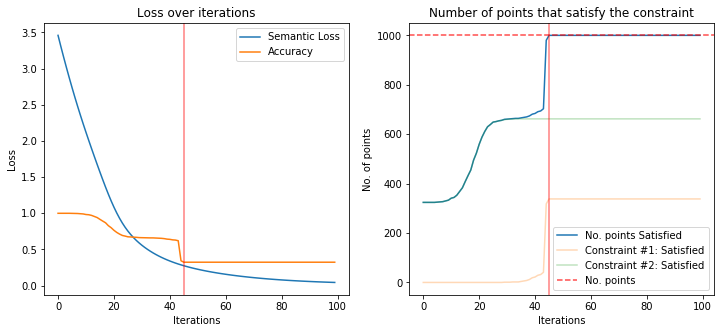

In [125]:
fig = plt.figure(figsize=(12, 5))

# first position at which # of points == 1000
sat_pos = sat_ot.index(1000)

ax = fig.add_subplot(121)
ax.plot(loss_ot, label="Semantic Loss")
ax.plot(acc_ot, label="Accuracy")
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.set_title("Loss over iterations")
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)


ax = fig.add_subplot(122)
ax.plot(sat_ot, label="No. points Satisfied")
ax.plot(sat_1_ot, label="Constraint #1: Satisfied", alpha=0.3)
ax.plot(sat_2_ot, label="Constraint #2: Satisfied", alpha=0.3)
ax.axhline(1000, 0, len(sat_ot), label="No. points", linestyle="--", color="red", alpha=0.7)
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("No. of points")
ax.set_title("Number of points that satisfy the constraint")

plt.savefig("./gaussian_blobs_exp3.png", dpi=300)

## Experiment 4

TODO Description

In [6]:
def experiment(net_fn, n_points = 1000, n_test=200, learning_rate=0.1, random_seed=2):
    
    def run_experiment(percent_data, w, n_iter=100, val_percent = 0.1):
        assert percent_data + val_percent <= 1.0 
        n_train = int(percent_data * X.size(0))
        n_val = int(val_percent * X.size(0))
        rand_idx = np.random.permutation(np.arange(X.size(0)))
        train_idx = rand_idx[:n_train]
        val_idx = rand_idx[n_train: n_train + n_val]
        
        X_train = X[train_idx]
        y_train = y[train_idx]
        
        X_val = X[val_idx]
        y_val = y[val_idx]
        
        net = net_fn()
        opt = optim.Adam(net.parameters())
        
        best_val_wts = net.state_dict()
        best_val_acc = float("-inf")
        
        for i in range(n_iter):
            net.train()
            opt.zero_grad()
            
            out = net(X_train)
            bce = F.binary_cross_entropy_with_logits(out, y_train)
            batch_loss = torch.zeros(X_train.size(0))
            for i, o in enumerate(out):
                batch_loss[i] = sem_loss(torch.sigmoid(o))
            sl = w * batch_loss.mean()
            loss = bce + sl
            loss.backward()
            opt.step()
            
            # compute val accuracy
            with torch.no_grad():
                net.eval()
                out = torch.sigmoid(net(X_val))
                correct = (out.argmax(dim=1) == y_val.argmax(dim=1)).sum()
                accuracy = float(correct) / X_val.size(0)

                if accuracy > best_val_acc:
                    best_val_acc = accuracy
                    best_val_wts = net.state_dict()
        
        # load with best model
        net.load_state_dict(best_val_wts)
            
        net.eval()
        with torch.no_grad():
            out = torch.sigmoid(net(X_test))
            correct = (out.argmax(dim=1) == y_test.argmax(dim=1)).sum()
            accuracy = float(correct) / X_test.size(0)
        
        print("N points: {}, w:{}, Best Val Accuracy: {}, Accuracy: {}".format(n_train, w, best_val_acc, accuracy))
            
        return {"accuracy": accuracy}
        
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    
    XX, yyy = make_blobs(n_points, n_features=3, random_state=random_seed)


    X = XX[:n_points - n_test]
    yy = yyy[:n_points - n_test]

    X_test = XX[n_points - n_test:]
    yy_test = yyy[n_points - n_test:]

    X = torch.FloatTensor(X)
    X_test = torch.FloatTensor(X_test)

    y = torch.zeros(X.size(0), 3)
    for idx, _ in enumerate(yy):
        y[idx, _] = 1.0

    y_test = torch.zeros(X_test.size(0), 3)
    for idx, _ in enumerate(yy_test):
        y_test[idx, _] = 1.0

    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.1, c=y)
    ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test)
    ax.view_init(elev=10, azim=45)
    ax.grid(False)
    
    plt.savefig("gauss_exp2.png")
    plt.close()
    
    w_choices = [0, 1, 2]
    percent_data = [0.1, 0.25, 0.5, 0.75, 0.9]
    experiments = []
    
    for w in w_choices:
        for p in percent_data:
            experiments.append({
                "percent_data": p,
                "w": w
            })
    
    results = []
    for experiment in experiments:
        results.append({
            "params": experiment,
            "results": run_experiment(experiment["percent_data"], experiment["w"])
        })
    
    with open("./gauss_blobs_results.json", "w") as writer:
        writer.write(json.dumps(results, indent=1))
    
    

    # convert to pytorch tensors
    
    
    
experiment(Net, random_seed=2)

N points: 80, w:0, Best Val Accuracy: 0.6875, Accuracy: 0.63
N points: 200, w:0, Best Val Accuracy: 0.325, Accuracy: 0.31
N points: 400, w:0, Best Val Accuracy: 0.3375, Accuracy: 0.405
N points: 600, w:0, Best Val Accuracy: 0.2875, Accuracy: 0.24
N points: 720, w:0, Best Val Accuracy: 0.6125, Accuracy: 0.575
N points: 80, w:1, Best Val Accuracy: 0.3, Accuracy: 0.3
N points: 200, w:1, Best Val Accuracy: 0.6625, Accuracy: 0.74
N points: 400, w:1, Best Val Accuracy: 0.525, Accuracy: 0.365
N points: 600, w:1, Best Val Accuracy: 0.0, Accuracy: 0.0
N points: 720, w:1, Best Val Accuracy: 0.6375, Accuracy: 0.72
N points: 80, w:2, Best Val Accuracy: 0.4125, Accuracy: 0.34
N points: 200, w:2, Best Val Accuracy: 0.4875, Accuracy: 0.365
N points: 400, w:2, Best Val Accuracy: 0.3125, Accuracy: 0.355
N points: 600, w:2, Best Val Accuracy: 0.025, Accuracy: 0.03
N points: 720, w:2, Best Val Accuracy: 0.6125, Accuracy: 0.555
